# Term Project - Data Mining - CSE 5334

#### Name: Pranit Jaiswal
#### UTA-ID: 1001816023

# Goal: Given the review, Predict the rating
#### (Use the board game geek review data)
###### Download Link for data: https://www.kaggle.com/jvanelteren/boardgamegeek-reviews

Given data contains 13M records of user ratings and reviews for board games.   
We need to build a classifier which can predict 'rating' (1 to 10) as output when the input is 'review'.

# 1. Import all required libraries

In [1]:
# imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import csv
import nltk
import pickle
import operator

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

import time

# 2. Importing Data 

_____________________________________________________________________________________________________________________________
a) Read data from CSV (Hosted on server)   
b) Store data into dataframe
_____________________________________________________________________________________________________________________________

In [2]:
start_time = time.time()

# Read data from csv and store into dataframe
comments_df = pd.read_csv("bgg-13m-reviews.csv")
# comments_df = pd.read_csv("http://download1347.mediafire.com/sgcfbmwpbqlg/m6k7mro06zypw8t/bgg-13m-reviews.csv")

end_time = time.time()
print("runtime: %s sec" % (end_time - start_time))

runtime: 13.126911640167236 sec


_____________________________________________________________________________________________________________________________
b) Check length of dataframe to verify if all the records are read properly which should be approx 13M
_____________________________________________________________________________________________________________________________

In [3]:
original_df_len = len(comments_df)
print("Original length of dataset:", original_df_len)

Original length of dataset: 13170073


In [4]:
if(original_df_len >= 13170073):
    print("All records in the csv file are successfully loaded in dataframe!")
else:
    print("You might have missed some data from csv file while reading.")

All records in the csv file are successfully loaded in dataframe!


_______________________________________________________________________________________________________________________________
c) Print and analyze dataframe for a rough idea before refining data
_______________________________________________________________________________________________________________________________

In [5]:
# Print Dataframe
comments_df

,Unnamed: 0,user,rating,comment,ID,name
0,0,sidehacker,10.0,NaN,13,Catan
1,1,Varthlokkur,10.0,NaN,13,Catan
2,2,dougthonus,10.0,"Currently, this sits on my list as my favorite...",13,Catan
3,3,cypar7,10.0,"I know it says how many plays, but many, many ...",13,Catan
4,4,ssmooth,10.0,NaN,13,Catan
...,...,...,...,...,...,...
13170068,3356495,pswissler,3.0,NaN,8256,LEGO Constructionary Game
13170069,3356496,Sprayoncrayon,3.0,"Lego created a version of Pictionary, only you...",8256,LEGO Constructionary Game
13170070,3356497,PhoenixSong,2.5,This game is very similar to Creationary. It c...,8256,LEGO Constructionary Game
13170071,3356498,tsantos,2.0,This game was really bad. Worst that I've pla...,8256,LEGO Constructionary Game


# 3. Refining data

## 3.a) Drop unwanted columns

As we can see, there are few unwanted columns other than 'rating' and 'comment' present in the dataframe which will be of no use while building classifier, so we can drop those columns

In [6]:
# Drop unwanted columns
comments_df = comments_df.drop(['Unnamed: 0', 'user', 'ID', 'name'], axis=1)

In [7]:
# Print Dataframe after dropping unwanted columns
comments_df

,rating,comment
0,10.0,NaN
1,10.0,NaN
2,10.0,"Currently, this sits on my list as my favorite..."
3,10.0,"I know it says how many plays, but many, many ..."
4,10.0,NaN
...,...,...
13170068,3.0,NaN
13170069,3.0,"Lego created a version of Pictionary, only you..."
13170070,2.5,This game is very similar to Creationary. It c...
13170071,2.0,This game was really bad. Worst that I've pla...


## 3.b) Ignore null values of 'rating' and 'review'

Also, we can see that there are NaN values present in reviews which are should not be considered to build classifier.   
So, we will redefine our dataframe by ignoring the NaN values

In [8]:
# Ignore records having null rating and null reviews
comments_df.dropna(inplace = True)

In [9]:
# Print Dataframe after ignoring null values of 'rating' and 'review'
comments_df

,rating,comment
2,10.0,"Currently, this sits on my list as my favorite..."
3,10.0,"I know it says how many plays, but many, many ..."
7,10.0,i will never tire of this game.. Awesome
11,10.0,This is probably the best game I ever played. ...
16,10.0,Fantastic game. Got me hooked on games all ove...
...,...,...
13170066,3.0,Horrible party game. I'm dumping this one!
13170067,3.0,Difficult to build anything at all with the in...
13170069,3.0,"Lego created a version of Pictionary, only you..."
13170070,2.5,This game is very similar to Creationary. It c...


In [10]:
# Check length of new dataframe after removing null value records
refined_df_len = len(comments_df)
print("Refined length of dataset:", refined_df_len)

Refined length of dataset: 2637756


_______________________________________________________________________________________________________________________________

Compare Size of original Datframe vs Refined Dataframe
_______________________________________________________________________________________________________________________________

In [11]:
percent_reduction = 100 - ((refined_df_len / original_df_len) * 100)
print("Percent Reduction in data after refining: {:.2f}%".format(percent_reduction))

Percent Reduction in data after refining: 79.97%


_______________________________________________________________________________________________________________________________
It was a very good decision to ingore records with empty values as there is massive reduction in size of the dataframe
_______________________________________________________________________________________________________________________________

## 3.c) Convert all words to lower case

We must convert all words to lower case which may increase accuracy of classifier   
Example:   
Classifier may treat "Good" and "good" as two different words while computing word frequencies.

In [12]:
# Convert all text into lowercase
comments_df['comment'] = comments_df['comment'].str.lower()

In [13]:
# Print Dataframe after converting all words to lower case
comments_df

,rating,comment
2,10.0,"currently, this sits on my list as my favorite..."
3,10.0,"i know it says how many plays, but many, many ..."
7,10.0,i will never tire of this game.. awesome
11,10.0,this is probably the best game i ever played. ...
16,10.0,fantastic game. got me hooked on games all ove...
...,...,...
13170066,3.0,horrible party game. i'm dumping this one!
13170067,3.0,difficult to build anything at all with the in...
13170069,3.0,"lego created a version of pictionary, only you..."
13170070,2.5,this game is very similar to creationary. it c...


## 3.d) Round off Rating Values

Check the distinct ratings present in the dataframe

In [14]:
distinct_rating = comments_df['rating'].unique()
print("Distinct Ratings", distinct_rating)
print("Total count of distinct ratings:", len(distinct_rating))

Distinct Ratings [10.       9.999    9.99    ...  6.4567   9.314    7.98525]
Total count of distinct ratings: 3408


______________________________________________________________________________________________________________________________
Oops... It contains 3408 distinct ratings which is a huge number for prediction result.   
Also, we don't want continuous rating values, we need absolute rating values between (1 to 10)   
So, it is better to round off all rating values before proceeding with the classifier
_______________________________________________________________________________________________________________________________

In [15]:
# Round off ratings to get ratings between [1 to 10]
fine_rating = comments_df['rating'].round()

In [16]:
print("Unique rating values after refinement:", fine_rating.unique())

Unique rating values after refinement: [10.  9.  8.  7.  6.  5.  4.  3.  2.  1.  0.]


In [17]:
comments_df['rating'] = fine_rating

In [18]:
# Print dataframe after rounding off all ratings between (1 to 10)
comments_df

,rating,comment
2,10.0,"currently, this sits on my list as my favorite..."
3,10.0,"i know it says how many plays, but many, many ..."
7,10.0,i will never tire of this game.. awesome
11,10.0,this is probably the best game i ever played. ...
16,10.0,fantastic game. got me hooked on games all ove...
...,...,...
13170066,3.0,horrible party game. i'm dumping this one!
13170067,3.0,difficult to build anything at all with the in...
13170069,3.0,"lego created a version of pictionary, only you..."
13170070,2.0,this game is very similar to creationary. it c...


## 3.e) Check count of each rating value

In [19]:
ratings_counts = comments_df['rating'].value_counts().sort_index(ascending=False)
print("Count of each rating value:\n", ratings_counts)

Count of each rating value:
 10.0    153530
9.0     239410
8.0     657581
7.0     574586
6.0     526481
5.0     217766
4.0     136565
3.0      70974
2.0      40766
1.0      20086
0.0         11
Name: rating, dtype: int64


_______________________________________________________________________________________________________________________________
Replace rating value '0.0' with rating value '1.0' as the count of rating value '0.0' is very low as compared to other.   
Also, previously we decided to keep the rating values only between (1 to 10)
_______________________________________________________________________________________________________________________________

In [20]:
# Replace rating value '0.0' with rating value '1.0'
comments_df['rating'] = comments_df['rating'].replace([0.0], 1.0)

_______________________________________________________________________________________________________________________________
Print count of each rating after merging 
_______________________________________________________________________________________________________________________________

In [21]:
ratings_counts = comments_df['rating'].value_counts().sort_index(ascending=False)
print("Count of each rating after merging:\n", ratings_counts)

Count of each rating after merging:
 10.0    153530
9.0     239410
8.0     657581
7.0     574586
6.0     526481
5.0     217766
4.0     136565
3.0      70974
2.0      40766
1.0      20097
Name: rating, dtype: int64


_______________________________________________________________________________________________________________________________
Draw Graph to better visualize count of each rating
_______________________________________________________________________________________________________________________________

[(10097, 707581)]

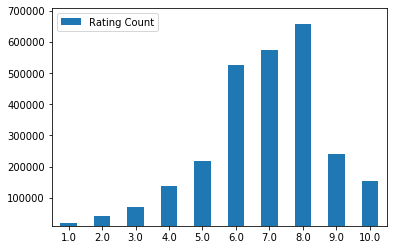

In [22]:
ratings_count_list = sorted(ratings_counts.items(), key=operator.itemgetter(1), reverse=False)
min_count = ratings_count_list[0][1]

ratings_count_list = sorted(ratings_counts.items(), key=operator.itemgetter(1), reverse=True)
max_count = ratings_count_list[0][1]

ratings_count_list = sorted(ratings_counts.items(), key=operator.itemgetter(0), reverse=False)

ratingVal = [item[0] for item in ratings_count_list]
countVal = [item[1] for item in ratings_count_list]

df = pd.DataFrame({'Rating Count': countVal}, index=ratingVal)

ax = df.plot.bar(rot=0)
ax.set(ylim=[min_count-10000, max_count+50000])

## 3.f) Convert all Rating Values to integer

Convert all 'rating' values to integer values.

In [23]:
comments_df['rating'] = comments_df['rating'].astype(int)

In [24]:
# Print dataframe after converting rating values to integer
comments_df

,rating,comment
2,10,"currently, this sits on my list as my favorite..."
3,10,"i know it says how many plays, but many, many ..."
7,10,i will never tire of this game.. awesome
11,10,this is probably the best game i ever played. ...
16,10,fantastic game. got me hooked on games all ove...
...,...,...
13170066,3,horrible party game. i'm dumping this one!
13170067,3,difficult to build anything at all with the in...
13170069,3,"lego created a version of pictionary, only you..."
13170070,2,this game is very similar to creationary. it c...


# 4. Using small part of data for building classifier

As we can see, even after refining the data we are getting more than 2.6M records.   
Building a classifier using such huge amount of data on a machine with limited resources may end up in:
1. Lack of processing speed
2. Memory error

Even if there will be sufficient resources and even if we use libraries then also:
1. In Naive Bayes, Word Frequency and Probability Computing time will be very high.
2. In SVM, it will take a huge time for computation of hyperplane.
3. In SVM, as the value of C will increase, computation time will increase.
4. In Random Forest Classifier, computing time & memory usage will be very high with increasing number of trees in the forest.   

5. If KNN is considered, then Distance Computing time will be very high.

Conclusion:
1. Use largest possible dataset for feasible computation for all algorithms we will try to implement.   
2. Make sure we take data containing all distinct 'rating' values, otherwise it is possible that you may miss all or very large amount of records for a particular rating.   
3. Maintain Ratio of each distinct 'rating' value to maintain consistency.

In [25]:
# Take smaller dataset for computation (80% size of original dataset)
# Maintain count ratio for each rating
small_df = comments_df.groupby('rating').apply(lambda x: x.sample(frac=0.8))

In [26]:
original_len_small_df = len(small_df)
print(original_len_small_df)

2110206


# 5. Refining small dataframe

1. Remove non-ASCII characters
2. Remove non-English characters
3. Remove special characters
4. Remove stop words

In [27]:
# Function to remove non-ASCII
def remove_non_ascii(text):
    return ''.join(i for i in text if ord(i)<128)

# Remove non-ASCII characters
small_df['comment'] = small_df['comment'].apply(remove_non_ascii)

# Remove non-English characters
small_df['comment'] = small_df['comment'].str.strip()         
small_df['comment'] = small_df['comment'].replace(r"[^a-zA-Z\d\_]+", "")

# Remove special characters
small_df['comment'] = small_df['comment'].replace([";",":","=","\+","<", ">", "\?", "!", "\\\\", "@", "#", "$", "\*", "%", ",", "\.", "\(", "\)", "\[", "\]", "\{", "\}", "\"", "/br"], "", regex = True)
small_df['comment'] = small_df['comment'].replace(["' ", " '"], " ", regex = True)

______________________________________________________________________________________________________________________________
After refining this new dataframe, few 'review' values may go blank.   
Remove those blank rows from this small dataframe.
______________________________________________________________________________________________________________________________

In [28]:
# Remove blank 'reviews' introduced after removing refinement of small dataframe
small_df = small_df[small_df['comment'] != '']

In [29]:
len_after_refining_small_df = len(small_df)
print(len_after_refining_small_df)

2098782


______________________________________________________________________________________________________________________________
Print refined small-dataframe
______________________________________________________________________________________________________________________________

In [30]:
small_df

rating                                            comment
rating                                                                    
1      11234428       1                             no strategy whatsoever
       6113301        1  no never again  in real life i really don't li...
       5071198        1  un verdadero coazo de reglas seguro que al fin...
       12020839       1  without doubt the worst gaming experience i ha...
       7930903        1  i've met better logistics games just not my genre
...                 ...                                                ...
10     11288958      10  simply the best solo wargame i ever played and...
       6064910       10  i hate dominion but apparently if you slap a t...
       11405432      10  mean silly random - yet it's incredible fun in...
       5709664       10  i've wanted a game like this for a long time b...
       253044        10  just a great game  even if i lose i still enjo...

[2098782 rows x 2 columns]

# 6. Dividing dataset into train, dev, and test

Train - 70%   
Dev - 15%   
Test - 15%

In [31]:
# Divide small_df into train, dev, and test
train, dev, test = np.split(small_df.sample(frac=1), [int(.7*len(small_df)), int(.85*len(small_df))])

# 7. Create X and y for train, dev, and test

References: 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html   
https://stackabuse.com/text-classification-with-python-and-scikit-learn/

* To build classifiers (to train and predict):   
We will need X and y for each dataset   
   
   
* The term frequency is calculated as:   
Term frequency = (Number of Occurrences of a word)/(Total words in the records)   
   
   
* And the Inverse Document Frequency is calculated as:   
IDF(word) = Log((Total number of records)/(Number of records containing the word))

The TFIDF value for a word in a particular record is higher if the frequency of occurrence of that word is higher in that specific record but lower in all the other records.

In [32]:
# min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold
# In our case we will set it to 0.002 to ignore vocabulary having document frequency lower than 0.2%
tfidfconverter = TfidfVectorizer(min_df=0.002)

# For train data - use fit_transform
X_train = tfidfconverter.fit_transform(train['comment']).toarray()

# For dev and test - use transform
X_dev_arr = tfidfconverter.transform(dev['comment']).toarray()
X_test_arr = tfidfconverter.transform(test['comment']).toarray()
X_dev = tfidfconverter.transform(dev['comment'])
X_test = tfidfconverter.transform(test['comment'])

# Put 'rating' column of each dataframe into y
y_train = np.asarray(train['rating'])
y_dev = np.asarray(dev['rating'])
y_test = np.asarray(test['rating'])

# 8. Building multiple classifiers

We will build and compare multiple classifiers which may be useful for text classification:
1. Naive Bayes Classifier
3. SVM (Support Vector Machine) Classifier
4. Random Forest Classifier
5. k-Nearest Neighbour Classifier

In [33]:
# Use following dictionaries to store results of all classifiers
mse_dict = dict()
accuracy_dict = dict()
classifier_dict = dict()

## 8.1 Naive Bayes Classifier
  
References:   
* https://www.reddit.com/r/MachineLearning/comments/2uhhbh/difference_between_binomial_multinomial_and/co8xxls/
* https://scikit-learn.org/stable/modules/naive_bayes.html   
   
Naive Bayes Classifier is one of the successful method for text classification.   
We have following Naive Bayes Classifiers:   

* Bernoulli Naive Bayes:    
The binomial model is useful if your feature vectors are binary (i.e., 0s and 1s). One application would be text classification with a bag of words model where the 0s 1s are "word occurs in the document" and "word does not occur in the document"
   
   
* Multinomial Naive Bayes:   
The multinomial naive Bayes model is typically used for discrete counts. E.g., if we have a text classification problem, we can take the idea of bernoulli trials one step further and instead of "word occurs in the document" we have "count how often word occurs in the document", you can think of it as "number of times outcome number x_i is observed over the n trials"
   
   
* Gaussian Naive Bayes:   
Here, we assume that the features follow a normal distribution. Instead of discrete counts, we have continuous features (e.g., the popular Iris dataset where the features are sepal width, petal width, sepal length, petal length).
   
Looking at the above description, we can conclude that only Multinomial Naive Bayes is useful in our case.
But just for the confirmation, we will also try Gaussian Naive Bayes.

### 8.1 a) Gaussian Naive Bayes

In [34]:
start_time = time.time()

# Train and Predict the data using Guassian Naive Bayes
gaussianNB = GaussianNB()
gaussianNB.fit(X_train, y_train)
classifier_dict["Gaussian Naive Bayes"] = gaussianNB;
y_pred_gnb_dev = gaussianNB.predict(X_dev_arr)

# Calculate the Mean Squared Error and Accuracy
mse_gnb_dev = mean_squared_error(y_dev, y_pred_gnb_dev)
accuracy_gnb_dev = accuracy_score(y_dev, y_pred_gnb_dev)*100

# Print the Mean Squared Error and Accuracy
print("Using Gaussian Naive Bayes:")
print("Mean Squared Error:", mse_gnb_dev)
print("Accuracy:", accuracy_gnb_dev)

# Store the Mean Squared Error and Accuracy in dictionaries
mse_dict["Gaussian Naive Bayes"] = mse_gnb_dev;
accuracy_dict["Gaussian Naive Bayes"] = accuracy_gnb_dev;

end_time = time.time()
print("runtime: %s sec" % (end_time - start_time))

Using Gaussian Naive Bayes:
Mean Squared Error: 12.583434185574477
Accuracy: 14.701239132575433
runtime: 446.3000693321228 sec


### 8.1 b) Multinomial Naive Bayes

In [35]:
start_time = time.time()

# Train and Predict the data using Multinomial Naive Bayes
multinomialNB = MultinomialNB(alpha=1)
multinomialNB.fit(X_train, y_train)
classifier_dict["Multinomial Naive Bayes"] = multinomialNB;
y_pred_mnb_dev = multinomialNB.predict(X_dev)

# Calculate the Mean Squared Error and Accuracy
mse_mnb_dev = mean_squared_error(y_dev, y_pred_mnb_dev)
accuracy_mnb_dev = accuracy_score(y_dev, y_pred_mnb_dev)*100

# Print the Mean Squared Error and Accuracy
print("Using Multinomial Naive Bayes:")
print("Mean Squared Error:", mse_mnb_dev)
print("Accuracy:", accuracy_mnb_dev)

# Store the Mean Squared Error and Accuracy in dictionaries
mse_dict["Multinomial Naive Bayes"] = mse_mnb_dev;
accuracy_dict["Multinomial Naive Bayes"] = accuracy_mnb_dev;

end_time = time.time()
print("runtime: %s sec" % (end_time - start_time))

Using Multinomial Naive Bayes:
Mean Squared Error: 2.9227900653395467
Accuracy: 31.144124999602944
runtime: 108.11284971237183 sec


_______________________________________________________________________________________________________________________________
Looking at the results, we can confirm - for text classification, Multinomial Naive Bayes is better than Gaussian Naive Bayes.
_______________________________________________________________________________________________________________________________

## 8.2 SVM (Support Vector Machine) Classifier

References:   
* https://monkeylearn.com/text-classification-support-vector-machines-svm/   
* https://scikit-learn.org/stable/modules/svm.html   
* https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python
   
   
There are many different algorithms we can choose from when doing text classification with machine learning. One of those is Support Vector Machines (or SVM).   
   
   
Support vector machines is an algorithm that determines the best decision boundary between vectors that belong to a given group (or category) and vectors that do not belong to it. That’s it. It can be applied to any kind of vectors which encode any kind of data. This means that in order to leverage the power of svm text classification, texts have to be transformed into vectors.   

As we have already transformed our texts into vectors, we can directly start training and predicting.   
   
   
According to the documentation of 'scikit-learn':   
For large datasets consider using sklearn.svm.LinearSVC and not sklearn.svm.SVC   
So, we will go with sklearn.svm.LinearSVC   

Regularization:   
Regularization parameter in python's Scikit-learn C parameter used to maintain regularization. Here C is the penalty parameter, which represents misclassification or error term. The misclassification or error term tells the SVM optimization how much error is bearable. This is how you can control the trade-off between decision boundary and misclassification term. A smaller value of C creates a small-margin hyperplane and a larger value of C creates a larger-margin hyperplane.   
   
   
Let's try different values of C (1, 100, 1000)

### 8.2 a) SVM (C=1)

In [36]:
start_time = time.time()

# Train and Predict the data using Linear SVM (C=1)
linearSVC1 = LinearSVC(C=1, dual=False)
linearSVC1.fit(X_train, y_train)
classifier_dict["Linear SVC (C=1)"] = linearSVC1;
y_pred_lsvc = linearSVC1.predict(X_dev)

# Calculate the Mean Squared Error and Accuracy
mse_lsvc1_dev = mean_squared_error(y_dev, y_pred_lsvc)
accuracy_lsvc1_dev = accuracy_score(y_dev, y_pred_lsvc)*100

# Print the Mean Squared Error and Accuracy
print("Using Linear SVC (C=1):")
print('Mean Squared Error:', mse_lsvc1_dev)
print('Accuracy:', accuracy_lsvc1_dev)

# Store the Mean Squared Error and Accuracy in dictionaries
mse_dict["Linear SVC (C=1)"] = mse_lsvc1_dev;
accuracy_dict["Linear SVC (C=1)"] = accuracy_lsvc1_dev;

end_time = time.time()
print("runtime: %s sec" % (end_time - start_time))

Using Linear SVC (C=1):
Mean Squared Error: 2.7691833668448655
Accuracy: 32.42042202295302
runtime: 293.71144700050354 sec


### 8.2 b) SVM (C=100)

In [37]:
start_time = time.time()

# Train and Predict the data using Linear SVM (C=100)
linearSVC100 = LinearSVC(C=100, dual=False)
linearSVC100.fit(X_train, y_train)
classifier_dict["Linear SVC (C=100)"] = linearSVC100;
y_pred_lsvc = linearSVC100.predict(X_dev)

# Calculate the Mean Squared Error and Accuracy
mse_lsvc100_dev = mean_squared_error(y_dev, y_pred_lsvc)
accuracy_lsvc100_dev = accuracy_score(y_dev, y_pred_lsvc)*100

# Print the Mean Squared Error and Accuracy
print("Using Linear SVC (C=100):")
print('Mean Squared Error:', mse_lsvc100_dev)
print('Accuracy:', accuracy_lsvc100_dev)

# Store the Mean Squared Error and Accuracy in dictionaries
mse_dict["Linear SVC (C=100)"] = mse_lsvc100_dev;
accuracy_dict["Linear SVC (C=100)"] = accuracy_lsvc100_dev;

end_time = time.time()
print("runtime: %s sec" % (end_time - start_time))

Using Linear SVC (C=100):
Mean Squared Error: 2.7688784277850305
Accuracy: 32.42868078915688
runtime: 308.7099573612213 sec


### 8.2 c) SVM (C=1000)

In [38]:
start_time = time.time()

# Train and Predict the data using Linear SVM (C=1000)
linearSVC1000 = LinearSVC(C=1000, dual=False)
linearSVC1000.fit(X_train, y_train)
classifier_dict["Linear SVC (C=1000)"] = linearSVC1000;
y_pred_lsvc = linearSVC1000.predict(X_dev)

# Calculate the Mean Squared Error and Accuracy
mse_lsvc1000_dev = mean_squared_error(y_dev, y_pred_lsvc)
accuracy_lsvc1000_dev = accuracy_score(y_dev, y_pred_lsvc)*100

# Print the Mean Squared Error and Accuracy
print("Using Linear SVC (C=1000):")
print('Mean Squared Error:', mse_lsvc1000_dev)
print('Accuracy:', accuracy_lsvc1000_dev)

# Store the Mean Squared Error and Accuracy in dictionaries
mse_dict["Linear SVC (C=1000)"] = mse_lsvc1000_dev;
accuracy_dict["Linear SVC (C=1000)"] = accuracy_lsvc1000_dev;

end_time = time.time()
print("runtime: %s sec" % (end_time - start_time))

Using Linear SVC (C=1000):
Mean Squared Error: 2.7689927799324687
Accuracy: 32.42772785459489
runtime: 305.33183431625366 sec


## 8.3 Random Forest Classifier

References:
* https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html   
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier   
* https://en.wikipedia.org/wiki/Random_forest   
   
   
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In other words, Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set.

We will set the maximum depth of tree to 100 for better results.   
I used this value after doing some testing on the data. (<100 : Low Accuracy, >100 : Large computing time)   

The number of trees in the forest (n_estimators) is considerd as one of the most important factor for getting better accuracy.   
We will use n_estimators = 10, 20, 50 to check the results.

In [39]:
start_time = time.time()

# Train and Predict the data using Random Forest Classifier (n_estimators=10)
randomForest10 = RandomForestClassifier(max_depth=100, n_estimators=10, max_features=1)
randomForest10.fit(X_train, y_train)
classifier_dict["Random Forest Classifier (n_estimators=10)"] = randomForest10;
y_pred_rfc = randomForest10.predict(X_dev)

# Calculate the Mean Squared Error and Accuracy
mse_rfc10_dev = mean_squared_error(y_dev, y_pred_rfc)
accuracy_rfc10_dev = accuracy_score(y_dev, y_pred_rfc)*100

# Print the Mean Squared Error and Accuracy
print("Using Random Forest Classifier (n_estimators=10):")
print('Mean Squared Error:', mse_rfc10_dev)
print('Accuracy:', accuracy_rfc10_dev)

# Store the Mean Squared Error and Accuracy in dictionaries
mse_dict["Random Forest Classifier (n_estimators=10)"] = mse_rfc10_dev;
accuracy_dict["Random Forest Classifier (n_estimators=10)"] = accuracy_rfc10_dev;

end_time = time.time()
print("runtime: %s sec" % (end_time - start_time))

Using Random Forest Classifier (n_estimators=10):
Mean Squared Error: 4.047688021930201
Accuracy: 25.52339930816951
runtime: 120.12788987159729 sec


In [40]:
start_time = time.time()

# Train and Predict the data using Linear SVM (n_estimators=20)
randomForest20 = RandomForestClassifier(max_depth=100, n_estimators=20, max_features=1)
randomForest20.fit(X_train, y_train)
classifier_dict["Random Forest Classifier (n_estimators=20)"] = randomForest20;
y_pred_rfc = randomForest20.predict(X_dev)

# Calculate the Mean Squared Error and Accuracy
mse_rfc20_dev = mean_squared_error(y_dev, y_pred_rfc)
accuracy_rfc20_dev = accuracy_score(y_dev, y_pred_rfc)*100

# Print the Mean Squared Error and Accuracy
print("Using Random Forest Classifier (n_estimators=20):")
print('Mean Squared Error:', mse_rfc20_dev)
print('Accuracy:', accuracy_rfc20_dev)

# Store the Mean Squared Error and Accuracy in dictionaries
mse_dict["Random Forest Classifier (n_estimators=20)"] = mse_rfc20_dev;
accuracy_dict["Random Forest Classifier (n_estimators=20)"] = accuracy_rfc20_dev;

end_time = time.time()
print("runtime: %s sec" % (end_time - start_time))

Using Random Forest Classifier:

Mean Squared Error: 3.9489608248601566
Accuracy: 26.000819523723308
runtime: 160.13300490379333 sec


In [41]:
start_time = time.time()

# Train and Predict the data using Linear SVM (n_estimators=50)
randomForest50 = RandomForestClassifier(max_depth=100, n_estimators=50, max_features=1)
randomForest50.fit(X_train, y_train)
classifier_dict["Random Forest Classifier (n_estimators=50)"] = randomForest50;
y_pred_rfc = randomForest50.predict(X_dev)

# Calculate the Mean Squared Error and Accuracy
mse_rfc50_dev = mean_squared_error(y_dev, y_pred_rfc)
accuracy_rfc50_dev = accuracy_score(y_dev, y_pred_rfc)*100

# Print the Mean Squared Error and Accuracy
print("Using Random Forest Classifier (n_estimators=50):")
print('Mean Squared Error:', mse_rfc50_dev)
print('Accuracy:', accuracy_rfc50_dev)

# Store the Mean Squared Error and Accuracy in dictionaries
mse_dict["Random Forest Classifier (n_estimators=50)"] = mse_rfc50_dev;
accuracy_dict["Random Forest Classifier (n_estimators=50)"] = accuracy_rfc50_dev;

end_time = time.time()
print("runtime: %s sec" % (end_time - start_time))

Using Random Forest Classifier:

Mean Squared Error: 3.981268482959942
Accuracy: 26.414710768478194
runtime: 312.39597153663635 sec


## 8.4 k-Nearest Neighbour Classifier
Reference:   
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

I tried using k-Nearest Neighbour Classifier, but I removed it after following observations:   
For large size of text data-   
1. It was taking very high computation time for each value of k due to limited resources.   
2. Mean square error was much higher than other classifiers   
3. Accuracy was significantly less than other classifiers   
   
__________________________________________________________________________________________________________________

If you have enough computing resources and time to execute kNN-   
You can use the following code which I used earlier for testing:   

<a href="https://pranitjaiswal.netlify.com/files/kNN.txt" download>Click here to download kNN code</a>

# 9. Compare results obtained from different classifiers

We will compare and conclude which classifier is producing better result in terms of mean square error as well as accuracy.
Then we will check the result for test dataset using same classifier.

In [42]:
mse_dict_list = sorted(mse_dict.items(), key=operator.itemgetter(1), reverse=False)
accuracy_dict_list = sorted(accuracy_dict.items(), key=operator.itemgetter(1), reverse=True)

In [43]:
# Print Mean Square Error for each classifier
mse_dict_list

[('Linear SVC (C=100)', 2.7688784277850305),
 ('Linear SVC (C=1000)', 2.7689927799324687),
 ('Linear SVC (C=1)', 2.7691833668448655),
 ('Multinomial Naive Bayes', 2.9227900653395467),
 ('Random Forest Classifier (n_estimators=20)', 3.9489608248601566),
 ('Random Forest Classifier (n_estimators=50)', 3.981268482959942),
 ('Random Forest Classifier (n_estimators=10)', 4.047688021930201),
 ('Gaussian Naive Bayes', 12.583434185574477)]

In [44]:
# Print Accuracy for each classifier
accuracy_dict_list

[('Linear SVC (C=100)', 32.42868078915688),
 ('Linear SVC (C=1000)', 32.42772785459489),
 ('Linear SVC (C=1)', 32.42042202295302),
 ('Multinomial Naive Bayes', 31.144124999602944),
 ('Random Forest Classifier (n_estimators=50)', 26.414710768478194),
 ('Random Forest Classifier (n_estimators=20)', 26.000819523723308),
 ('Random Forest Classifier (n_estimators=10)', 25.52339930816951),
 ('Gaussian Naive Bayes', 14.701239132575433)]

_______________________________________________________________________________________________________________________________
Draw Graph to better visualize comparison between all Classifiers used
_______________________________________________________________________________________________________________________________

In [45]:
graph_classifier_list = [item[0] for item in mse_dict_list]
graph_mse_list = [item[1] for item in mse_dict_list]
graph_accuracy_list = [item[1] for item in accuracy_dict_list]

[(0, 14.583434185574477)]

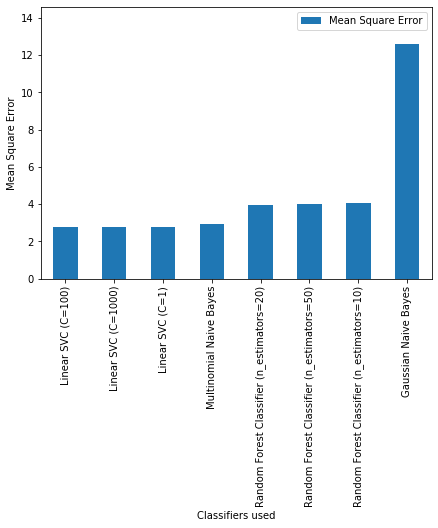

In [46]:
minY = 0;
maxY = max(graph_mse_list)

df = pd.DataFrame({'Mean Square Error': graph_mse_list}, index=graph_classifier_list)
ax = df.plot(figsize=(7,5), kind='bar', stacked=True)

ax. set(xlabel="Classifiers used", ylabel="Mean Square Error")

ax.set(ylim=[minY, maxY+2])

[(0, 34.42868078915688)]

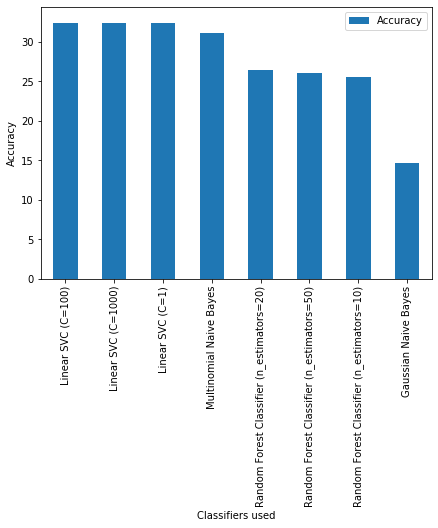

In [47]:
minY = 0;
maxY = max(graph_accuracy_list)

df = pd.DataFrame({'Accuracy': graph_accuracy_list}, index=graph_classifier_list)
ax = df.plot(figsize=(7,5), kind='bar', stacked=True)

ax. set(xlabel="Classifiers used", ylabel="Accuracy")

ax.set(ylim=[minY, maxY+2])

# 10. Conclusion - Find the Best Classifier

Based on the comparison above we will decide the best classifier along with its optimal hyperparameters.   
   
   
While dealing with large text data, after testing multiple times we can observe that SVM is the best Classifier for text classification.

In [60]:
# Find the classifier with lowest Mean Square Error
lowest_mse_classifier = mse_dict_list[0]

# Find the classifier with highest Accuracy
highest_accuracy_classifier = accuracy_dict_list[0]

print("Best Classifier considering lowest mean square error:", lowest_mse_classifier)
print("Best Classifier considering highest accuracy:", highest_accuracy_classifier)

Best Classifier considering lowest mean square error: ('Linear SVC (C=100)', 2.7688784277850305)
Best Classifier considering highest accuracy: ('Linear SVC (C=100)', 32.42868078915688)


_______________________________________________________________________________________________________
##### IMP Note:
If the best classifier predicted by us are different as per Mean Square Error and Accuracy then-   
I selected the classifier with low Mean Square Error.   
Because, result values are not only 0 and 1.   
We have 10 distinct values for result which may lead to low accuracy.   
It will be very difficult to decide the best classifier by looking at the accuracy if the difference is not considerable.   
To avoid this, in such cases we will select classifier with low mean square error as the Best Classifier for text data.
_______________________________________________________________________________________________________

In [61]:
# Assign and Print name of Best Classifier
best_classifier_name = mse_dict_list[0][0]
bestClassifier = classifier_dict.get(best_classifier_name)
print(bestClassifier)

LinearSVC(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


# 11. Calculate Final Results on Test Data using Best Classifier   

* Predict Values   
* Print Mean Squared Error & Accuracy

In [62]:
# Predict test data and get Results using Best Classifier
y_pred_test = bestClassifier.predict(X_test)

# Calculate the Mean Squared Error and Accuracy
mse_test = mean_squared_error(y_test, y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)*100

# Print the Mean Squared Error and Accuracy
print("Using Best Classifier:\n")
print('Mean Squared Error:', mse_test)
print('Accuracy:', accuracy_test)

Using Best Classifier:

Mean Squared Error: 2.7747079264845085
Accuracy: 32.40380156153714


# 12. Take dump of the Best Classifier model along with its vectorizer
This dump can be used to create a web application for rating prediction.

I have also created one Rating Predictor using our best classifier model:   
URL: http://ec2-107-21-86-146.compute-1.amazonaws.com:5000/predict


In [63]:
# Take dump of Best Classifier using Pickle
pickle.dump(bestClassifier, open('model.pkl', 'wb'))

# Take dump of Vectorizer using Pickle
pickle.dump(tfidfconverter, open('tfidfconverter1.pkl', 'wb'))

# Take extra dump of Vectorizer using Pickle
pickle.dump(tfidfconverter, open('tfidfconverter2.pickle', 'wb'))

# 13. Create an input field to predict rating entered by user:
You can Re-run the following block of code for predicting rating for different reviews.


In [65]:
input_review = input('Enter your review: ') 
mcom = {'comment': [input_review]}
mdf = pd.DataFrame(mcom, columns = ['comment'])
X_single = tfidfconverter.transform(mdf['comment'])
y_single = bestClassifier.predict(X_single)
print("Predicted Rating: ", y_single[0])
print()

Enter your review: worst
Predicted Rating:  1

